In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np

from utils import data_utils
from models import network

In [25]:
model = network.build_model()
model.load_weights('./ckpt/detector')
decoder = network.OutputDecoder(score_threshold=0.2)

In [26]:
inputs = model.input
out = decoder(model.output)
final_model = keras.models.Model(inputs, out)

In [30]:
val_ds = data_utils.get_val_dataset(batch_size=4)
train_ds = data_utils.get_train_dataset(batch_size=4)
for i in train_ds.take(2):
    sample = i
sample[0].shape, sample[1].shape

(TensorShape([4, 224, 224, 3]), TensorShape([4, 7, 7, 25]))

In [31]:
valid_num, nms_boxes, nms_scores, nmsed_classes = final_model.predict(sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 [ 60.71341  45.01876 151.5175  167.44827]
0 [145.2965   88.1394  185.14244 102.01006]
0 [75.37119  58.61105  96.71192  88.729195]
0 [148.43561  69.19552 189.7085  -37.54433]
0 [135.24852    31.03854   191.37138    -7.4928436]
1 [ 44.082245  15.611748 180.8789   208.56216 ]
1 [119.943565 181.55583  142.25194  216.62971 ]
1 [110.364746 148.58119  139.5511   190.54573 ]
1 [ 87.45221    9.483959 123.109406  47.055225]
1 [128.7334   82.80292 198.8818  105.60849]
2 [ 61.139534  66.07438  193.81552  235.91159 ]
2 [ 71.632706 103.721245  98.18739  193.15063 ]
3 [ 48.28383 101.91467 194.48398 197.10101]
3 [ 56.444855   6.807617 213.89322   72.70819 ]
3 [ 1.6144998e+02 -1.2296295e-01  2.3883801e+02  2.2064456e+02]
3 [104.68033 203.66614 196.76273 227.88956]
3 [105.866714  70.02031  184.72444  161.50395 ]
3 [107.136765 130.63887  185.99947  192.34462 ]
3 [ 54.469757 111.011246 125.64081  186.58205 ]


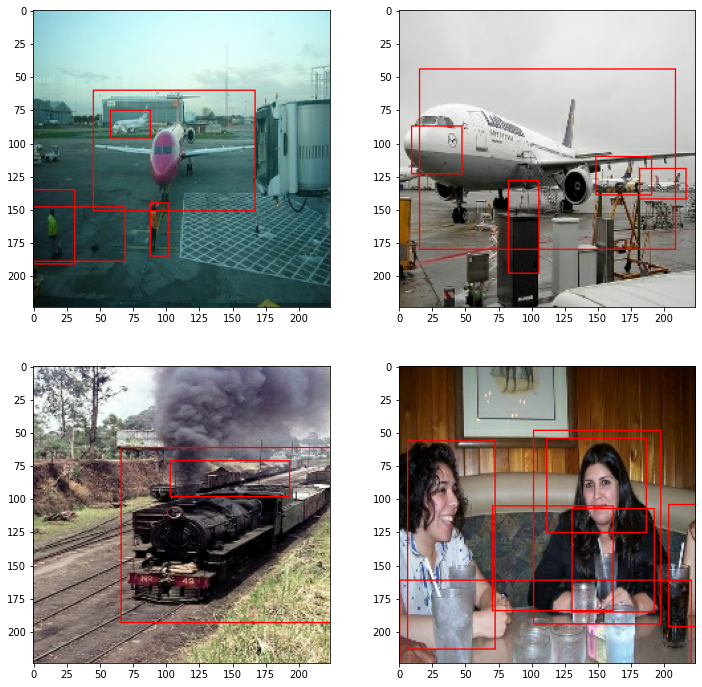

In [32]:
plt.figure(figsize=(12, 12))
for i in range(4):
    image = (sample[0][i].numpy() + 1) / 2
    for box in nms_boxes[i][:valid_num[i]]:
        print(i, box)
        pt1 = (int(box[1]), int(box[0]))
        pt2 = (int(box[3]), int(box[2]))
        image = cv2.rectangle(image, pt1, pt2, (255, 0, 0), 1)
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)

In [33]:
pred = model.predict(sample[0])

In [8]:
def get_confidence(conf, class_):
    confidence_score = class_ * conf
    return confidence_score

In [9]:
classes = tf.maximum(pred[..., 10:], 0.)

cond = tf.equal(classes, tf.reduce_max(classes, axis=[-1])[..., None])
classes = tf.where(cond, classes, tf.zeros_like(classes))

score1 = tf.maximum(pred[..., 4, None], 0.)
score1 = tf.reshape(get_confidence(score1, classes), (-1, 7 * 7, 20))
score2 = tf.maximum(pred[..., 4 + 5, None], 0.)
score2 = tf.reshape(get_confidence(score2, classes), (-1, 7 * 7, 20))
scores = tf.concat([score1, score2], axis=1)

In [10]:
tf.maximum(pred[..., 10:], 0.)[2, 2, 3]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.19062382, 0.01337794, 0.09648336, 0.        , 0.01354399,
       0.03430108, 0.12463775, 0.11597598, 0.09676876, 0.05471518,
       0.17533876, 0.00429745, 0.        , 0.03500545, 0.11741613,
       0.09628906, 0.03195423, 0.09642648, 0.        , 0.08319404],
      dtype=float32)>

In [11]:
cond[2, 2, 3]

<tf.Tensor: shape=(20,), dtype=bool, numpy=
array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])>

In [12]:
np.where(pred[2][..., 4] == pred[2][..., 4].max())

(array([2], dtype=int64), array([4], dtype=int64))

In [13]:
pred[2, 2, 3, :5]

array([ 0.53402793,  1.3018337 ,  0.07816059,  0.14714296, -0.24813224],
      dtype=float32)

In [14]:
pred[2, 2, 3, 5:10]

array([ 2.3487354e-02,  1.9540193e+00, -1.2047431e+00,  8.9990206e-02,
       -1.7011287e-03], dtype=float32)